In [181]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

In [182]:
# константы
#  ядро для генератора случайных чисел
my_seed = 14
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
#mpl.style.use('seaborn-whitegrid')
#sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
#sns.color_palette("flare", as_cmap=True)
sns.set_palette("husl", 8, .75)

In [183]:
# читаем таблицу из файла .csv во фрейм
fileURL = "https://raw.githubusercontent.com/ania607/ML/main/data/College_for_lab.csv"
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (777, 9)


In [184]:
# первые 5 строк фрейма
DF_raw.head(5)

,Grad_Rate,Accept,Top10perc,Top25perc,F_Undergrad,P_Undergrad,PhD,Expend,Private
0,60,1232,23,52,2885,537,70,7041,Yes
1,56,1924,16,29,2683,1227,29,10527,Yes
2,54,1097,22,50,1036,99,53,8735,Yes
3,59,349,60,89,510,63,92,19016,Yes
4,15,146,16,44,249,869,76,10922,Yes


In [185]:
# типы столбцов фрейма
DF_raw.dtypes

Grad_Rate       int64
Accept          int64
Top10perc       int64
Top25perc       int64
F_Undergrad     int64
P_Undergrad     int64
PhD             int64
Expend          int64
Private        object
dtype: object

In [186]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

Grad_Rate      0
Accept         0
Top10perc      0
Top25perc      0
F_Undergrad    0
P_Undergrad    0
PhD            0
Expend         0
Private        0
dtype: int64

In [187]:
# кодируем категориальную переменную
# частный
priv_dict = {'Yes' : 1, 'No' : 0}
DF_raw['PrivateYes'] = DF_raw.Private.map(priv_dict)

In [188]:
# объединяем с исходным фреймом
DF_all = pd.concat([DF_raw.reset_index(drop=True)], axis=1)

# сколько теперь столбцов
DF_all.shape

(777, 10)

In [189]:
# смотрим какие получились столбцы 
DF_all.iloc[:, :].head()

,Grad_Rate,Accept,Top10perc,Top25perc,F_Undergrad,P_Undergrad,PhD,Expend,Private,PrivateYes
0,60,1232,23,52,2885,537,70,7041,Yes,1
1,56,1924,16,29,2683,1227,29,10527,Yes,1
2,54,1097,22,50,1036,99,53,8735,Yes,1
3,59,349,60,89,510,63,92,19016,Yes,1
4,15,146,16,44,249,869,76,10922,Yes,1


In [190]:
# смотрим последние 5 столбцов
DF_all.iloc[:, 5:].head()

,P_Undergrad,PhD,Expend,Private,PrivateYes
0,537,70,7041,Yes,1
1,1227,29,10527,Yes,1
2,99,53,8735,Yes,1
3,63,92,19016,Yes,1
4,869,76,10922,Yes,1


In [191]:
# оставляем в наборе данных только то, что нужно 
DF_all = DF_all[['Grad_Rate','Accept','Top10perc','Top25perc','F_Undergrad','P_Undergrad','PhD',
                 'Expend','PrivateYes']]

DF_all.columns

Index(['Grad_Rate', 'Accept', 'Top10perc', 'Top25perc', 'F_Undergrad',
       'P_Undergrad', 'PhD', 'Expend', 'PrivateYes'],
      dtype='object')

In [192]:
DF_all.dtypes

Grad_Rate      int64
Accept         int64
Top10perc      int64
Top25perc      int64
F_Undergrad    int64
P_Undergrad    int64
PhD            int64
Expend         int64
PrivateYes     int64
dtype: object

In [193]:
# удаляем фрейм-исходник
del DF_raw

In [194]:
# данные для построения моделей
DF = DF_all.sample(frac=0.8, random_state = my_seed)

# данные для прогнозов
DF_predict = DF_all.drop(DF.index)

In [206]:
# описательные статистики для непрерывных переменных
DF[['Grad_Rate','Top10perc','F_Undergrad']].describe()

,Grad_Rate,Top10perc,F_Undergrad
count,622.000000,622.000000,622.000000
mean,65.374598,27.575563,3746.713826
std,17.365249,18.110412,4993.646724
min,10.000000,1.000000,139.000000
25%,53.000000,15.000000,973.250000
50%,65.000000,23.000000,1685.500000
75%,77.750000,35.000000,4292.750000
max,118.000000,96.000000,31643.000000


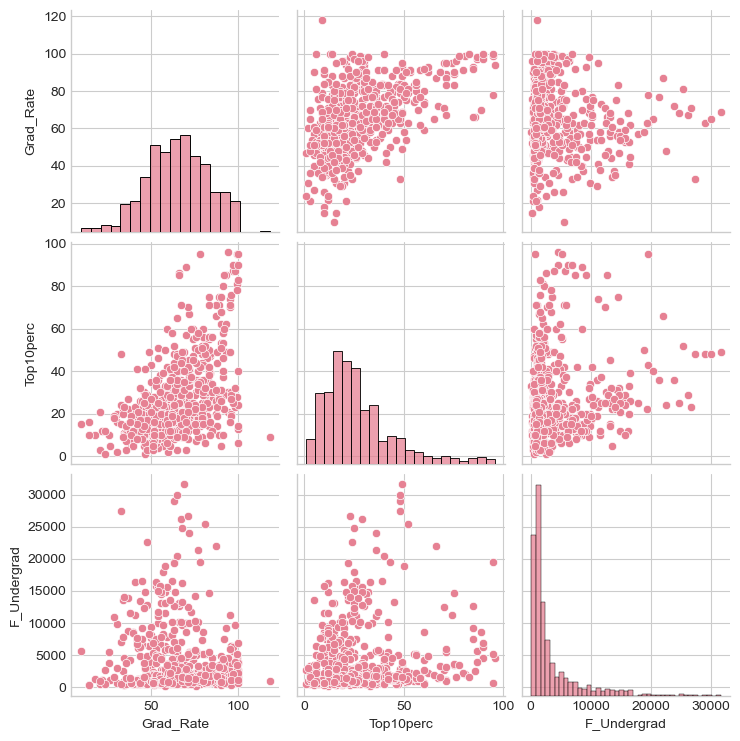

In [207]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['Grad_Rate','Top10perc','F_Undergrad']])
plt.show()

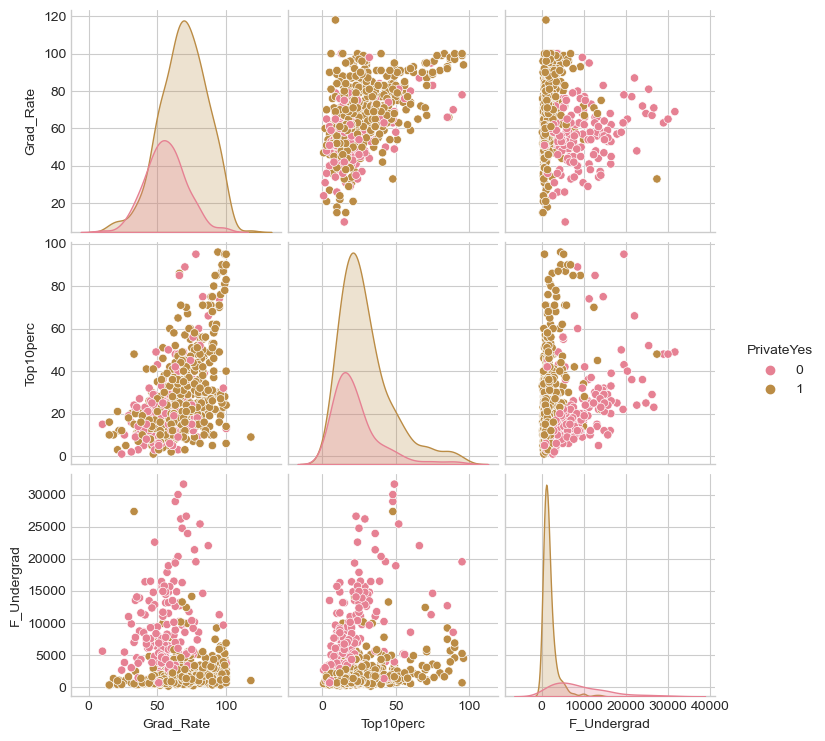

In [208]:
# матричный график разброса с цветом по частному или государственному университету
sns.pairplot(DF[['Grad_Rate','Top10perc','F_Undergrad','PrivateYes']],
            hue='PrivateYes')

plt.show()

In [209]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['Grad_Rate','Top10perc','F_Undergrad']].corr()
corr_mat.style.background_gradient(cmap ='PiYG').set_precision(2)
#corr_mat

C:\Users\user\AppData\Local\Temp\ipykernel_11540\1192244960.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap ='PiYG').set_precision(2)


,Grad_Rate,Top10perc,F_Undergrad
Grad_Rate,1.00,0.50,-0.08
Top10perc,0.50,1.00,0.15
F_Undergrad,-0.08,0.15,1.00


In [218]:
# корреляционная матрица по классу частных университетов
corr_mat = DF.loc[DF['PrivateYes']==1][['Grad_Rate','Top10perc','F_Undergrad']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat.style.background_gradient(cmap='PiYG').set_precision(2)

C:\Users\user\AppData\Local\Temp\ipykernel_11540\3453477987.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='PiYG').set_precision(2)


,Grad_Rate,Top10perc,F_Undergrad
Grad_Rate,1.00,0.48,0.15
Top10perc,0.48,1.00,0.33
F_Undergrad,0.15,0.33,1.00


In [219]:
# корреляционная матрица по классу государственных университетов
corr_mat = DF.loc[DF['PrivateYes']==0][['Grad_Rate','Top10perc','F_Undergrad']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat.style.background_gradient(cmap='PiYG').set_precision(2)

C:\Users\user\AppData\Local\Temp\ipykernel_11540\1593091591.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='PiYG').set_precision(2)


,Grad_Rate,Top10perc,F_Undergrad
Grad_Rate,1.00,0.48,0.25
Top10perc,0.48,1.00,0.45
F_Undergrad,0.25,0.45,1.00


In [213]:
# логарифмируем зависимую переменную
DF['log_Grad_Rate'] = np.log(DF['Grad_Rate'])

# описательные статистики для непрерывных показателей
DF[['Grad_Rate','log_Grad_Rate','Top10perc','F_Undergrad']].describe()

,Grad_Rate,log_Grad_Rate,Top10perc,F_Undergrad
count,622.000000,622.000000,622.000000,622.000000
mean,65.374598,4.138599,27.575563,3746.713826
std,17.365249,0.306296,18.110412,4993.646724
min,10.000000,2.302585,1.000000,139.000000
25%,53.000000,3.970292,15.000000,973.250000
50%,65.000000,4.174387,23.000000,1685.500000
75%,77.750000,4.353483,35.000000,4292.750000
max,118.000000,4.770685,96.000000,31643.000000


In [214]:
# тестируем на нормальность
for col in ['Grad_Rate', 'log_Grad_Rate']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

Grad_Rate Statistics=0.99, p=0.0388
Распределение не нормально (H0 отклоняется)

log_Grad_Rate Statistics=0.92, p=0.0000
Распределение не нормально (H0 отклоняется)



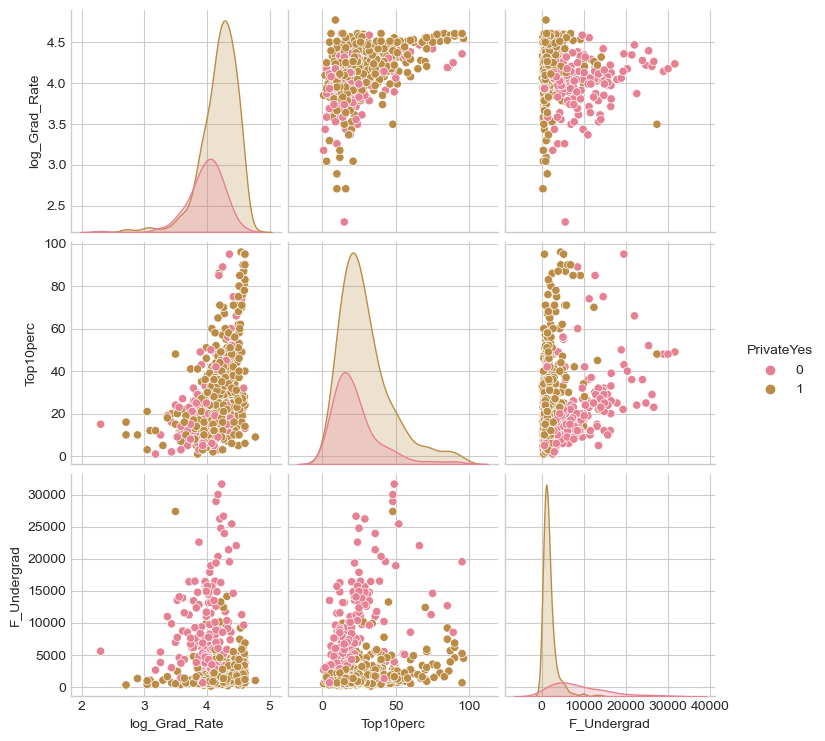

In [215]:
# матричный график разброса с цветом по частному или государственному университету
sns.pairplot(DF[['log_Grad_Rate','Top10perc','F_Undergrad','PrivateYes']],
            hue='PrivateYes')

plt.show()

In [220]:
# корреляционная матрица по классу частных университетов
corr_mat = DF.loc[DF['PrivateYes']==1][['log_Grad_Rate','Top10perc','F_Undergrad']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat.style.background_gradient(cmap='PiYG').set_precision(2)

C:\Users\user\AppData\Local\Temp\ipykernel_11540\3919961461.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='PiYG').set_precision(2)


,log_Grad_Rate,Top10perc,F_Undergrad
log_Grad_Rate,1.00,0.44,0.13
Top10perc,0.44,1.00,0.33
F_Undergrad,0.13,0.33,1.00


In [221]:
# корреляционная матрица по классу государственных университетов
corr_mat = DF.loc[DF['PrivateYes']==0][['log_Grad_Rate','Top10perc','F_Undergrad']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat.style.background_gradient(cmap='PiYG').set_precision(2)

C:\Users\user\AppData\Local\Temp\ipykernel_11540\1475415859.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='PiYG').set_precision(2)


,log_Grad_Rate,Top10perc,F_Undergrad
log_Grad_Rate,1.00,0.43,0.24
Top10perc,0.43,1.00,0.45
F_Undergrad,0.24,0.45,1.00


In [229]:
# данные для моделей 1, 5
df1 = DF[['Grad_Rate','PrivateYes','Top10perc','F_Undergrad']]

# данные для моделей 2, 6
df2 = DF[['Grad_Rate','PrivateYes','Top10perc','F_Undergrad']]
df2.loc[:,'Top10perc_PrivateYes'] = df2.loc[:, 'Top10perc'] * df2.loc[:,'PrivateYes']
df2=df2.drop(['Top10perc'],axis=1)

# данные для моделей 3, 7
df3=DF[['Grad_Rate','PrivateYes','Top10perc','F_Undergrad']]
df3.loc[:,'F_Undergrad_PrivateYes']=df3.loc[:,'F_Undergrad']*df3.loc[:,'PrivateYes']
df3=df3.drop(['F_Undergrad'],axis=1)

# данные для моделей 4, 8
df4 = DF[['Grad_Rate','PrivateYes','Top10perc','F_Undergrad']]
df4.loc[:,'Top10perc_PrivateYes'] = df4.loc[:,'Top10perc']*df4.loc[:,'PrivateYes']
df4.loc[:,'F_Undergrad_PrivateYes'] = df4.loc[:,'F_Undergrad']*df4.loc[:,'PrivateYes']
df4=df4.drop(['Top10perc','F_Undergrad'], axis=1)

# данные для моделей 9, 10
df0=DF.drop(['log_Grad_Rate','Accept','Top25perc','P_Undergrad', 'PhD', 'Expend'], axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_11540\121816302.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,'Top10perc_PrivateYes'] = df2.loc[:, 'Top10perc'] * df2.loc[:,'PrivateYes']
C:\Users\user\AppData\Local\Temp\ipykernel_11540\121816302.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.loc[:,'F_Undergrad_PrivateYes']=df3.loc[:,'F_Undergrad']*df3.loc[:,'PrivateYes']
C:\Users\user\AppData\Local\Temp\ipykernel_11540\121816302.py:16: SettingWithCopyWarning: 
A value is trying to be set

In [230]:
# проверка результатов
df4.head()

,Grad_Rate,PrivateYes,Top10perc_PrivateYes,F_Undergrad_PrivateYes
192,50,0,0,0
179,54,1,16,1057
636,59,1,42,7760
249,73,1,22,1464
408,83,1,14,601


In [231]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df0.drop(['Grad_Rate'], axis=1)
y = df0.Grad_Rate.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель fit_lm_0:
 константа  [45.603] 
 объясняющие  ['Top10perc', 'F_Undergrad', 'PrivateYes'] 
 коэффициенты  [[ 0.437  0.    10.342]]


In [232]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
np.sqrt(MSE)

array([14.36621589])

In [233]:
# модель со всеми объясняющими, y_log
X = df0.drop(['Grad_Rate'], axis=1)
y = np.log(df0.Grad_Rate).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)
print('модель fit_lm_0_log:\n', 
      'константа ', np.around(fit_lm_0_log.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [3.809] 
 объясняющие  ['Top10perc', 'F_Undergrad', 'PrivateYes'] 
 коэффициенты  [[0.007 0.    0.177]]


In [238]:
# пересчёт коэффициентов для их интерпретации
np.around((np.exp(fit_lm_0_log.coef_) - 1) * 100, 3)

array([[ 0.702,  0.   , 19.354]])

In [235]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0_log.predict(X)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
np.sqrt(MSE_log)

array([14.60442766])

In [239]:
print('MSE_train модели для Grad_Rate меньше MSE_train',
     'модели для log(Grad_Rate) в ', np.around(MSE_log / MSE, 3), 'раз')

MSE_train модели для Grad_Rate меньше MSE_train модели для log(Grad_Rate) в  [1.033] раз


In [240]:
# LeaveOneOut CV
loo = LeaveOneOut()

# модели для y
scores = []
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2 ,df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['Grad_Rate'], axis=1)
    y = df.Grad_Rate
    score = cross_val_score(lm, X, y, cv=loo,
                           scoring='neg_mean_squared_error').mean()    
    scores.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 23.76 секунд


In [241]:
df0.shape

(622, 4)

In [242]:
# модели для y_log
scores_log = list() 
# таймер
tic = time.perf_counter()
for df in [df0,df1,df2,df3,df4]:
    loo.get_n_splits(df)
    X = df.drop(['Grad_Rate'],axis=1)
    y = np.log(df.Grad_Rate)
    score = cross_val_score(lm, X, y, cv=loo, n_jobs=1,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 24.21 секунд


In [243]:
scores

[-209.04304202172318,
 -209.04304202172344,
 -219.98764572075794,
 -212.37923070231957,
 -225.9561304596242]

In [245]:
[np.around(-x, 2) for x in scores]

[209.04, 209.04, 219.99, 212.38, 225.96]

In [246]:
[np.around(-x, 3) for x in scores_log]

[0.07, 0.07, 0.073, 0.071, 0.075]

In [257]:
# самая точная на Grad_Rate
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_loocv =', np.around(-max(scores), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_0 :
MSE_loocv = 208.987


In [258]:
# самая точная на log(Grad_Rate)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_loocv =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_0_log :
MSE_loocv = 208.987


In [259]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0,df1,df2,df3,df4]:
    X = df.drop(['Grad_Rate'],axis=1)
    y = df.Grad_Rate
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.29 секунд


In [260]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores_log = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0,df1,df2,df3,df4]:
    X = df.drop(['Grad_Rate'],axis=1)
    y = df.Grad_Rate
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.28 секунд


In [261]:
scores

[-208.98650610019575,
 -209.63103615462347,
 -220.56812106399312,
 -213.37980381165707,
 -225.32835196977484]

In [263]:
# самая точная на Grad_Rate
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_kf10 =', np.around(-max(scores), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0 :
MSE_kf10 = 208.987


In [264]:
# самая точная на log(Grad_Rate)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_kf10 =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0_log :
MSE_kf10 = 208.987


In [266]:
# прогноз по fit_lm_0_log
# модель
X = df0.drop(['Grad_Rate'], axis=1)
y = np.log(df0.Grad_Rate).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['Grad_Rate']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['Grad_Rate','Accept','Top25perc','P_Undergrad', 'PhD', 'Expend'], axis=1)

#  прогнозы
y_pred = fit_lm_0_log.predict(X)

# ошибка
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0_log на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_0_log на отложенных наблюдениях = 192.27


In [267]:
# прогноз по fit_lm_0
#  модель на всех обучающих наблюдениях
X = df0.drop(['Grad_Rate'], axis=1)
y = df0.Grad_Rate.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['Grad_Rate']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['Grad_Rate','Accept','Top25perc','P_Undergrad', 'PhD', 'Expend'], axis=1)
#  прогнозы
y_pred = fit_lm_0.predict(X)

# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_0 на отложенных наблюдениях = 187.94


In [268]:
np.sqrt(MSE_log) / np.mean(DF_predict[['Grad_Rate']]) * 100

C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Grad_Rate    21.067052
dtype: float64

In [269]:
np.sqrt(MSE) / np.mean(DF_predict[['Grad_Rate']]) * 100

C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Grad_Rate    20.828342
dtype: float64

In [276]:
X = df0.drop(['Grad_Rate'], axis=1)
y = df0.Grad_Rate.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)

print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(df0.drop(['Grad_Rate'], axis=1).columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 5))

модель fit_lm_0:
 константа  [45.603] 
 объясняющие  ['Top10perc', 'F_Undergrad', 'PrivateYes'] 
 коэффициенты  [[4.366400e-01 5.000000e-05 1.034182e+01]]
